# Info

This notebook is for processing, checking, and analyzing the phenotypic data.

In [54]:
# Setup
library(tidyverse)
library(magrittr)
library(data.table)
library(ggplot2)
library(ggrepel)
library(wesanderson)
library(corrplot)
library(FactoMineR)
library(factoextra)
library(missMDA)
library(ggforce)
setwd('/n/hoekstra_lab_tier1/Users/brock/polionotus/pheno/')
assoc_dir = '/n/hoekstra_lab_tier1/Users/akautt/projects/Peromyscus_polionotus/results/association/'
#source('~/scripts/polionotus_project/R_polionotus_setup.R')

In [ ]:
project = "Peromyscus_polionotus"
stem_path = "/n/hoekstra_lab_tier1/Users/akautt/projects/"

#set main data folder for the project
project_dir = stem_path + project
data_dir = os.path.join(project_dir,'data')
results_dir = os.path.join(project_dir,'results')
scripts_dir = os.path.join(project_dir,'scripts')
log_dir = os.path.join(scripts_dir,'logs')
list_dir = os.path.join(project_dir,'lists')
assoc_dir = os.path.join(results_dir,'association')
if not os.path.exists(assoc_dir):
    os.mkdir(assoc_dir)
temp_dir = os.path.join(project_dir,'temp')
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)
emmax_dir = os.path.join(assoc_dir,'emmax')
if not os.path.exists(emmax_dir):
    os.mkdir(emmax_dir)
    
genome_path = '/n/holylfs03/LABS/hoekstra_lab/Lab/PUBLIC/GENOMES/Ppol1.3_chr_NCBI'
annot_path = '/n/holylfs03/LABS/hoekstra_lab/Lab/PUBLIC/ANNOTATIONS/Ppol1.3_chr_NCBI'
refseq = os.path.join(genome_path,'Ppol_1.3.3.chromosomes-unplaced_scaffolds.fasta')
annotation = os.path.join(annot_path,'Ppol1.3_chr_NCBI.corrected.merged-with-Apollo.May2020.sorted.gff3')

# Read data

Read in categorical scores from a few different datasets

In [33]:
alb_scores = 
    read.csv('./albifrons_scoring.csv', stringsAsFactors=F) %>% 
    mutate(pop = "ALB")
pol_scores = 
    read.table('./polionotus_skin_scores_062930.txt',fill=T,sep="\t",header=T, stringsAsFactors=F) %>% 
    filter(!is.na(FLANK)) %>% 
    dplyr::select(!c(ANIMALID,X)) %>% 
    dplyr::rename(ANIMALID=MCZ) %>%
    mutate(pop = NA,
          pop = ifelse(ANIMALID %in% c('68174','68180','68184','68186','64653','64654'),'POPOL',pop),
          pop = ifelse(ANIMALID %in% c('69677','69679','69686','69667','69673'),'LO',pop),
          pop = ifelse(ANIMALID %in% c('68144','68146','68147','68149','68152'),'PO',pop))
pol_scores_v2 =
    read.table('./polionotus_skin_scores_102620.txt',fill=T,sep="\t",header=T, stringsAsFactors=F) %>%
    mutate(ANIMALID = gsub("/.*","",ANIMALID) %>% gsub("MCZ","",.))

scores = rbind(alb_scores, pol_scores, pol_scores_v2)

Read in spectrophotometer data (quantitative)

In [34]:
spec = fread('spec/combined.csv',sep=",") %>% rename(c("folder"="ANIMALID")) %>% mutate(ANIMALID = gsub("MCZ","",ANIMALID))
spec %<>% mutate(filenum = as.numeric(gsub('.*_','',file)))
spec = merge(spec,
              scores %>% dplyr::select(ANIMALID,SPECDORSAL,SPECFLANK,SPECVENTRUM))
spec %<>% mutate(PART = NA,
                 PART = ifelse(grepl('5',SPECDORSAL) & filenum %in% c(1,2,3,4,5),"DORSAL",PART),
                 PART = ifelse(grepl('6',SPECDORSAL) & filenum %in% c(2,3,4,5,6),"DORSAL",PART),
                PART = ifelse(grepl('10',SPECFLANK) & filenum %in% c(6,7,8,9,10),"FLANK",PART),
                PART = ifelse(grepl('11',SPECFLANK) & filenum %in% c(7,8,9,10,11),"FLANK",PART),
                PART = ifelse(grepl('15',SPECVENTRUM) & filenum %in% c(11,12,13,14,15),"VENTRUM",PART),
                PART = ifelse(grepl('16',SPECVENTRUM) & filenum %in% c(12,13,14,15,16),"VENTRUM",PART))
spec %<>% filter(!is.na(PART))
writeable = spec %>% dplyr::select(ANIMALID,Brightness,Hue,Saturation,filenum,PART)
#write.table(writeable,'./spectrophotometer_data.txt',sep="\t",quote=F,col.names=T,row.names=F)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Write out combined data

In [35]:
summspec = 
    spec %>%
    gather("TRAIT","VALUE",Brightness,Hue,Saturation) %>% 
    dplyr::select(file,ANIMALID,PART,TRAIT,VALUE) %>%
    group_by(ANIMALID,PART,TRAIT) %>%
    mutate(VALUE = as.numeric(VALUE)) %>%
    summarize_at(vars(VALUE), funs(mean(.,na.rm=T),median(.,na.rm=T),sd(.,na.rm=T))) %>%
    dplyr::rename(MEAN=mean, MEDIAN=median,SD=sd) %>%
    ungroup
summspec %<>% 
    gather(stat,val,MEAN:SD) %>% 
    pivot_wider(id_cols = ANIMALID,names_from = c("PART","TRAIT","stat") ,values_from = c("val")) 
fwrite(summspec,'/n/hoekstra_lab_tier1/Users/brock/polionotus/pheno/spectrophotometer_data_summarized.csv')


pheno_master = left_join(scores, summspec)
#write.table(pheno_master,'polionotus_phenotypes.txt',quote=F,col.names=T,row.names=F,sep="\t")

Joining, by = "ANIMALID"



Exclude poor quality (genotype) samples from the trait data, as it will be more useful to compare values amongst individuals with actual genotypes

In [40]:
# run this to exclude samples with too much missing GT data
excluded_samples <- read.table(paste0(assoc_dir,'/POALB.miss50perc.samplelist.tsv'), header=F)[1] %>% unlist()

pheno_master_miss50perc <- pheno_master %>% filter(!ANIMALID %in% excluded_samples) %>%
    dplyr::rename("Ankleshadow"=ANKLESHADOW,"Cheek"=CHEEK,"Eyebrow"=EYEBROW,"Rostrum"=ROSTRUM,
           "Rumpshadow"=RUMPSHADOW,"Rumpshape"=RUMPSHAPE,"Tail"=TAIL,"Whisker"=WHISKER,
           "Ventrum"=VENTRUM,"Ventrum_Brightness"=VENTRUM_Brightness_MEDIAN,
           "Ventrum_Hue"=VENTRUM_Hue_MEDIAN,"Dorsum_Brightness"=DORSAL_Brightness_MEDIAN,
           "Dorsum_Hue"=DORSAL_Hue_MEDIAN,"Flank_Brightness"=FLANK_Brightness_MEDIAN,
           "Flank_Hue"=FLANK_Hue_MEDIAN,"Flank_Saturation"=FLANK_Saturation_MEDIAN,
           "Dorsum_Saturation"=DORSAL_Saturation_MEDIAN,"Ventrum_Saturation"=VENTRUM_Saturation_MEDIAN)

## Retain only albifrons individuals for the following analyses
pheno_master_miss50perc %>% filter(pop=="ALB") %>% nrow()

[1] 152

# Trait distributions

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.

Warning message:
“Removed 31 rows containing non-finite values (stat_bindot).”


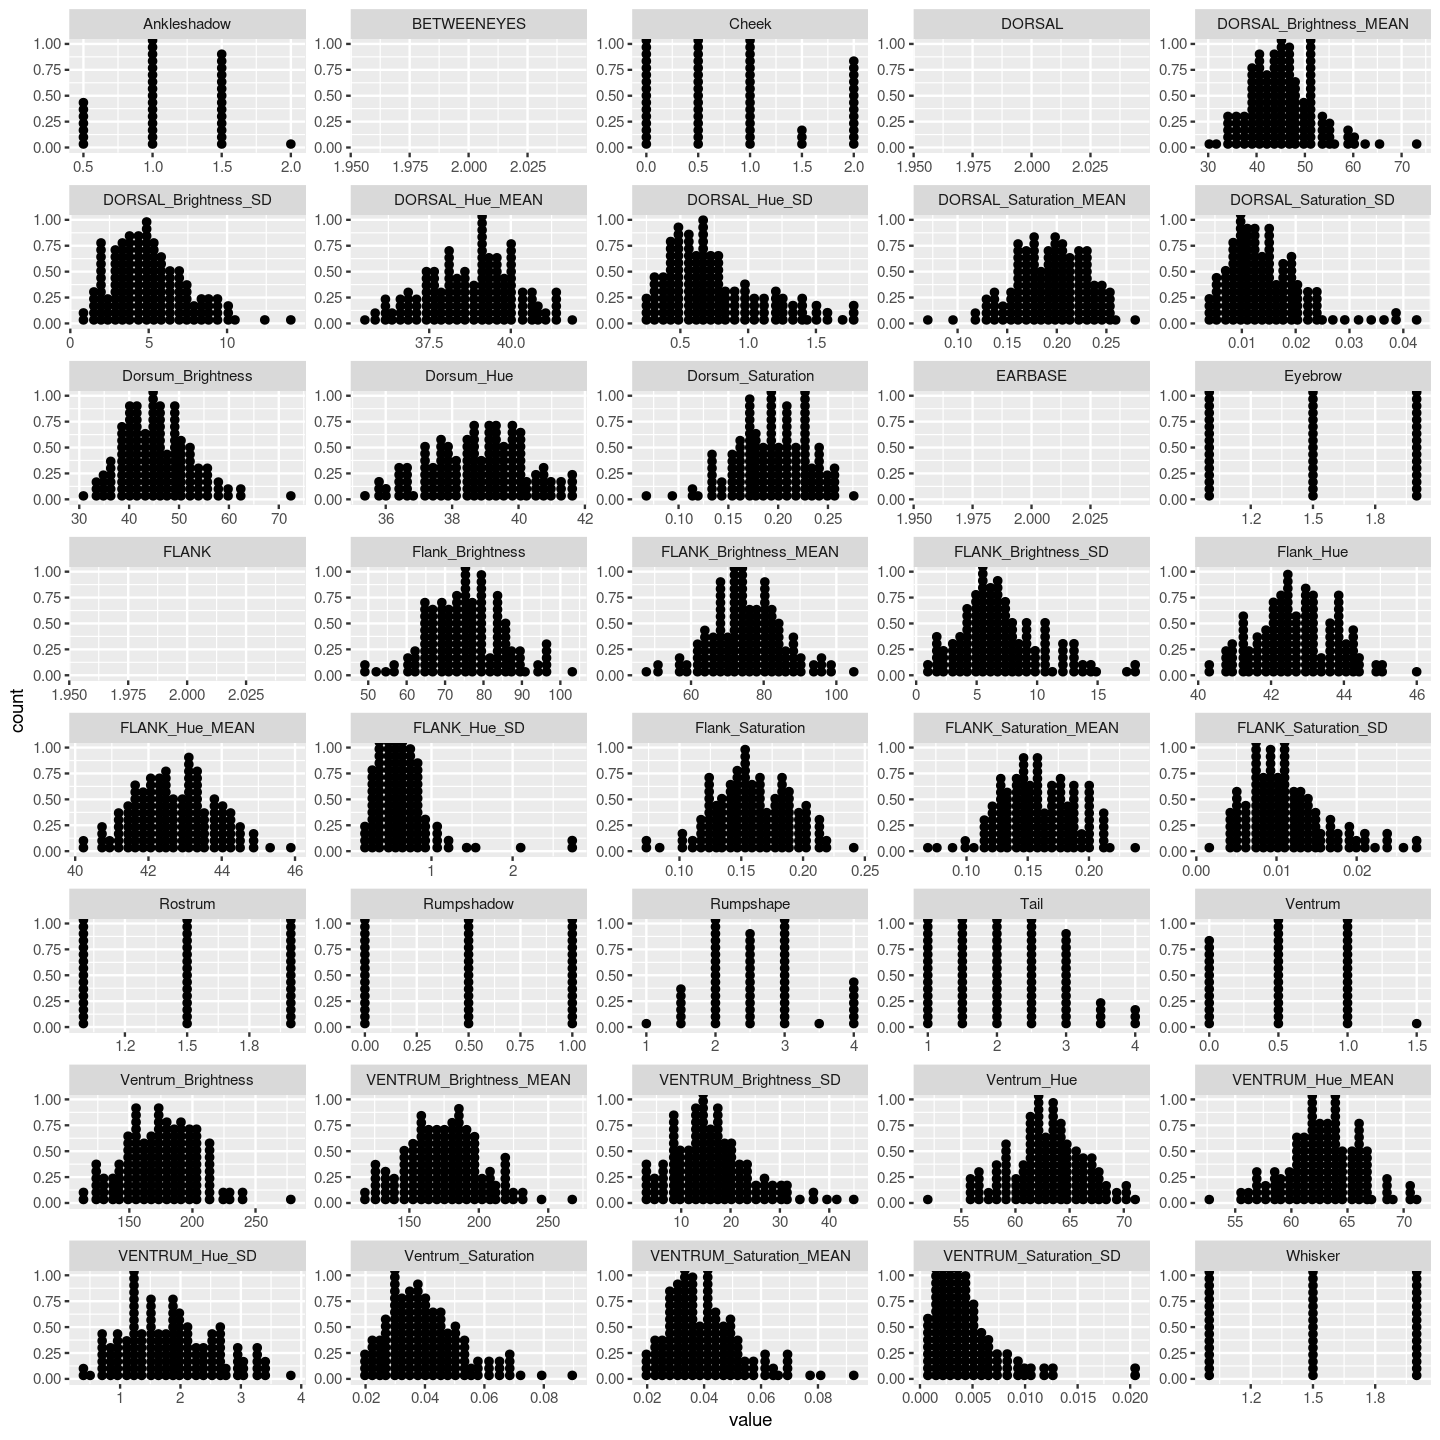

In [80]:
options(repr.plot.width = 12, repr.plot.height = 12)
pheno_master_miss50perc %>% 
    filter(pop=="ALB") %>% select(-c(ANIMALID,MEASURER,DATE,NOTES,pop,starts_with("SPEC"))) %>% 
    mutate(across(everything(),~as.numeric(.))) %>%
    gather() %>%     
    ggplot(aes(value)) + geom_dotplot() +
    facet_wrap(~key, scales="free", ncol=5)

Warning message:
“Removed 31 rows containing non-finite values (stat_boxplot).”


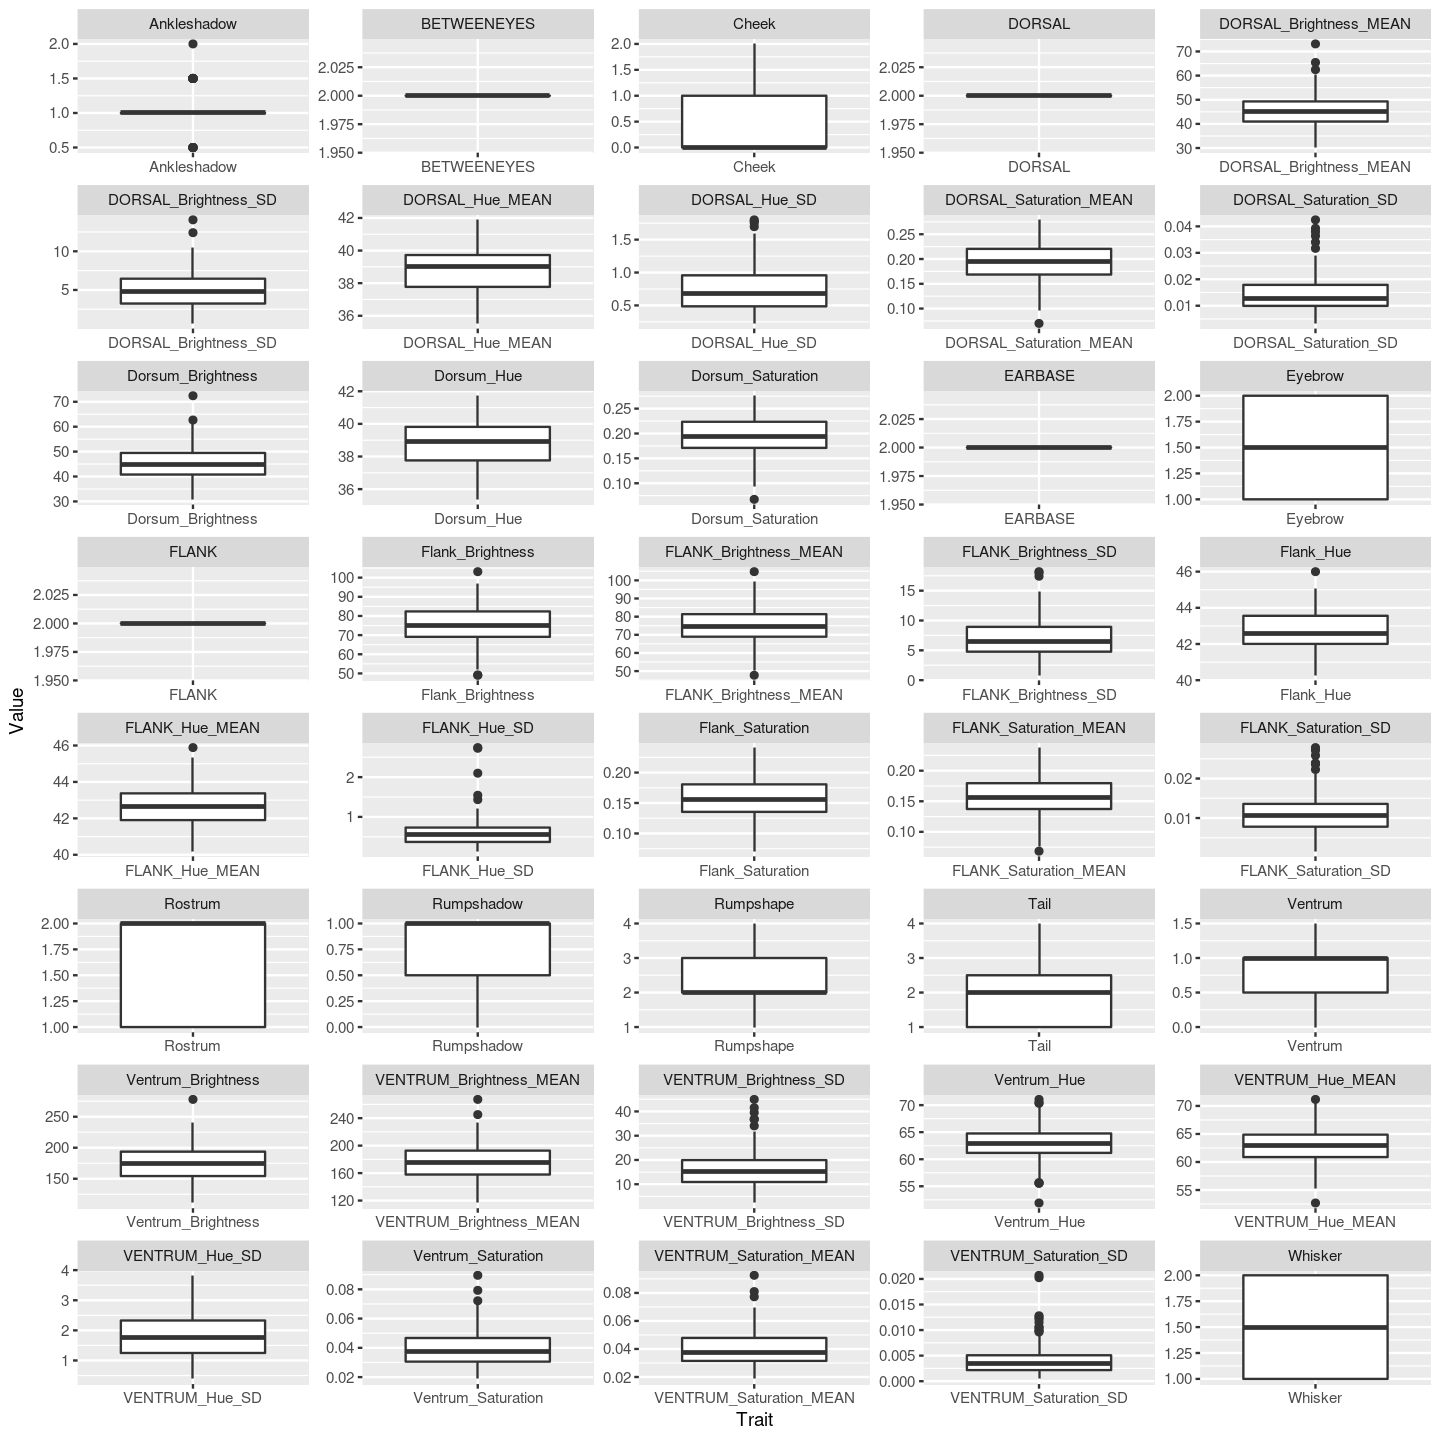

In [81]:
options(repr.plot.width = 12, repr.plot.height = 12)
pheno_master_miss50perc %>% 
    filter(pop=="ALB") %>% select(-c(ANIMALID,MEASURER,DATE,NOTES,pop,starts_with("SPEC"))) %>%
    mutate(across(everything(),~as.numeric(.))) %>%
    gather(key='Trait',value='Value') %>% 
    ggplot(aes(x=Trait,y=Value)) + geom_boxplot() +
    facet_wrap(~Trait, scales="free", ncol=5)

# PCA of trait data

Impute missing data (shouldn't be much for albifrons)

In [56]:
PCA_data <- pheno_master_miss50perc %>%
    filter(pop=="ALB") %>% 
    select(-c(ANIMALID,MEASURER,DATE,NOTES,pop,starts_with("SPEC"))) %>%
    select(-c(DORSAL,FLANK,EARBASE,BETWEENEYES,contains("_MEAN"),contains("_SD"))) %>% 
    as.data.frame() 

# estimate best number of dimensions used for imputation
nb <- estim_ncpPCA(PCA_data, method.cv="Kfold", verbose=F)
print(nb$ncp)

# impute missing data
PCA_data_impute <- imputePCA(PCA_data, ncp = nb$ncp)$completeObs

# run PCA and pull out first 5 PCs
res.pca <- PCA(PCA_data_impute, ncp=5, graph=F)  #ncp=nb$ncp,

[1] 5


Viz variance explained

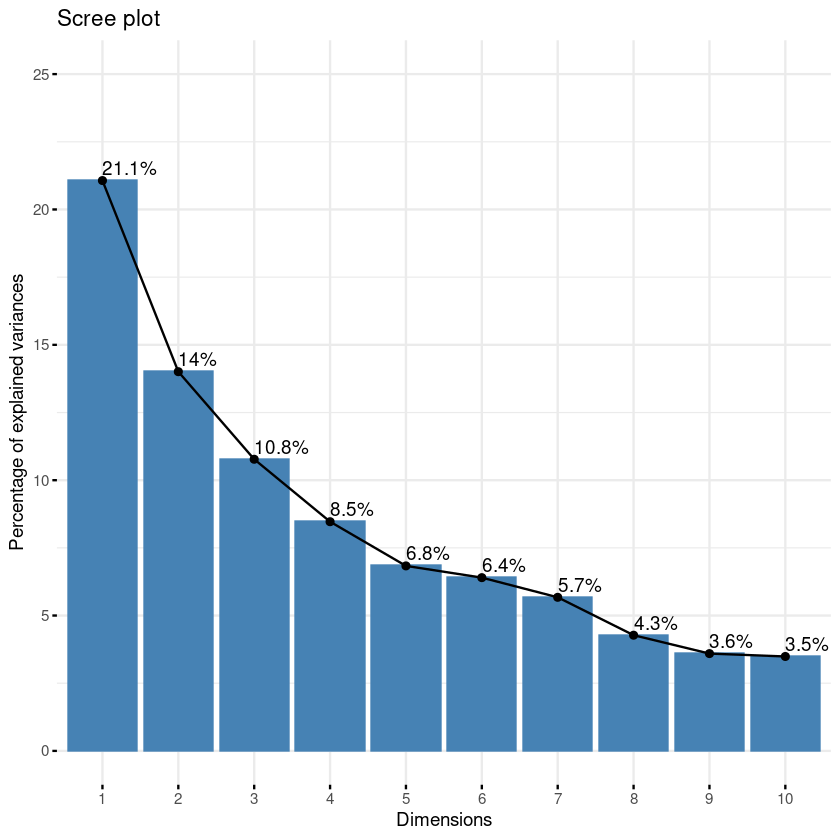

In [57]:
# scree plot
#pdf(paste0(assoc_dir,'traits.scree_plot.pdf'),width=6,height=2)
print(fviz_eig(res.pca, addlabels=T, ylim=c(0, 25), xlim=c(1,10)))
#dev.off()

Viz PC1 loadings

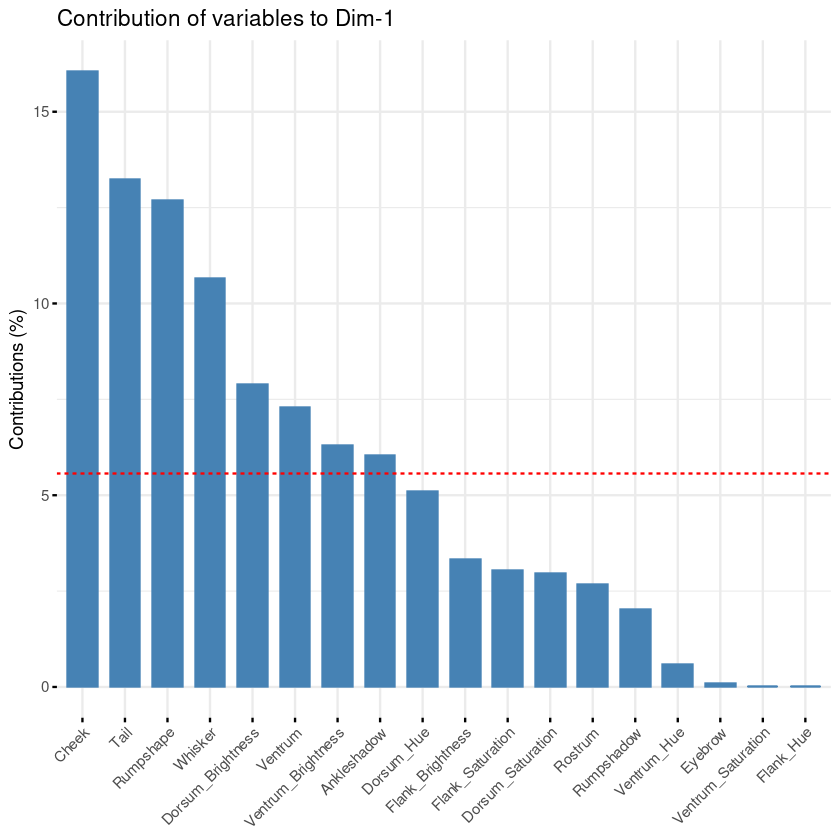

In [60]:
# contributions of variables to PC1
#pdf(paste0(assoc_dir,'/PC1.contributions_plot.pdf'),width=6,height=2)
print(fviz_contrib(res.pca, choice = "var", axes = 1, top = 30))
#dev.off()

#out_file = paste0(assoc_dir,'/PCA.contributions.tsv')
#if (!exists(out_file)) {
#    res.pca$var$contrib %>% as.data.frame() %>% rownames_to_column('Trait') %>%
#    write_tsv(out_file) }

Viz PC2 loadings

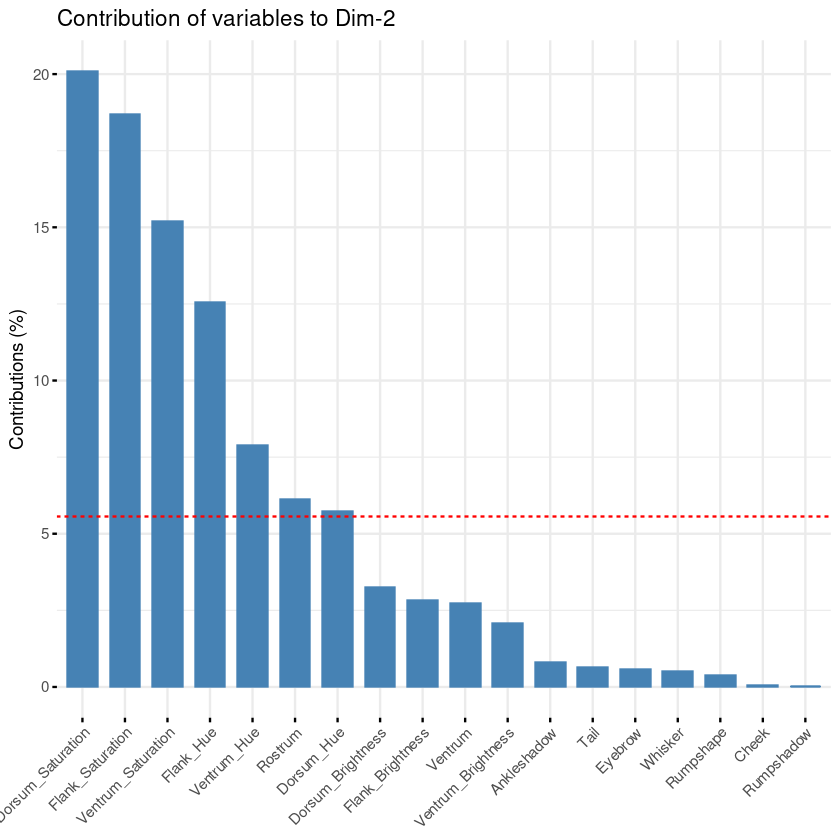

In [61]:
# contributions of variables to PC2
print(fviz_contrib(res.pca, choice = "var", axes = 2, top = 30))

Viz biplot

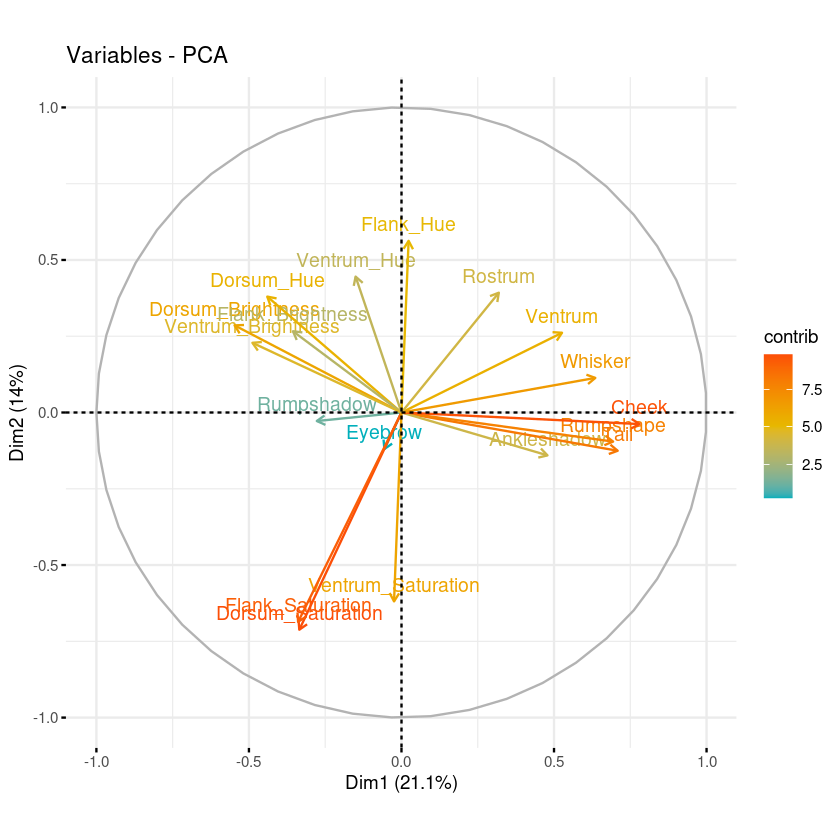

In [62]:
#pdf(paste0(assoc_dir,'/traits.PCA_contributions.pdf'),width=6,height=6)
print(fviz_pca_var(res.pca, col.var="contrib",  
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07")))
#dev.off()

Quick check trait correlations with first PC

In [63]:
res.desc <- dimdesc(res.pca, axes = c(1,2), proba = 0.05)
# Description of dimension 1
res.desc$Dim.1

,correlation,p.value
Cheek,0.7804258,2.122818e-32
Tail,0.7086470,1.739162e-24
Rumpshape,0.6936186,3.979895e-23
Whisker,0.6352744,1.488848e-18
Ventrum,0.5261634,3.365911e-12
Ankleshadow,0.4785087,4.512903e-10
Rostrum,0.3190483,6.169461e-05
Rumpshadow,-0.2774610,5.387042e-04
Dorsum_Saturation,-0.3348364,2.482038e-05
Flank_Saturation,-0.3388174,1.957160e-05


## Compare POALB to other pops (PC1)

Using pigment traits from other mainland and beach populations, project them onto the same axis as PC1

In [66]:
# RUMPSHADOW could not be reliably measured for SEBM samples - fill in NAs with overall mean to make PCA projection work
mock_value = mean(pheno_master_miss50perc$Rumpshadow, na.rm=T)
print(mock_value)

pheno_master_miss50perc.mockforNA <- pheno_master_miss50perc %>% 
    mutate(Rumpshadow=if_else(is.na(Rumpshadow),mock_value,Rumpshadow))

# pull out data for non-POALB samples
PCA_data.other_pops <- pheno_master_miss50perc.mockforNA %>%
    mutate(pop=if_else(is.na(pop),"UNK",as.character(pop))) %>%
    filter(pop!="ALB") %>% 
    select(-c(ANIMALID,pop,MEASURER,DATE,NOTES,starts_with("SPEC"))) %>%
    select(-c(DORSAL,FLANK,EARBASE,BETWEENEYES,contains("_MEAN"),contains("_SD"))) %>% 
    as.data.frame() 

# project onto POALB PCA space
proj.pca.other_pops <- predict(res.pca, PCA_data.other_pops)

# combine and add sample,pop info
PCA.all <- cbind(pheno_master_miss50perc %>% select(ANIMALID,pop),
                  rbind(res.pca$ind$coord, proj.pca.other_pops$coord)) %>%
            dplyr::rename(PC1=Dim.1, PC2=Dim.2, PC3=Dim.3, PC4=Dim.4, PC5=Dim.5)

[1] 0.5891892


Viz (Fig. 2C)

Joining, by = c("ANIMALID", "pop")

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Removed 16 rows containing non-finite values (stat_bin).”


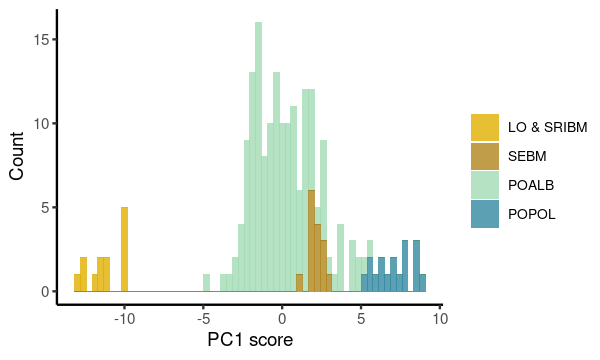

In [67]:
alltraits = left_join(allpheno, PCA.all)

options(repr.plot.height=3,repr.plot.width=5)
# Plot medians as well
meds = alltraits %>% filter(pop != "PO") %>% group_by(pop) %>% summarize(medPC1 = median(PC1,na.rm=T))


p = ggplot(alltraits %>% filter(!pop %in% c("PO"))) +
    geom_histogram(aes(x = PC1, fill = pop), bins = 60,alpha=0.8) +
    scale_fill_manual(name="",
                      values = c(wes_palette("Zissou1")[c(4)],"#AF841C","#a1dab4","#3488A1"),
                      limits = c("LO","SEBM","ALB","POPOL"),
                      labels = c(expression("LO & SRIBM"),
                                 expression("SEBM"),
                                 expression("POALB"),
                                 expression("POPOL"))) +
    ylab('Count') +
    xlab('PC1 score') +
    theme_classic() +
    theme(legend.text.align = 0, legend.position = "right", legend.text = element_text(size=8)) +
    guides(color=FALSE)

p
#ggsave('~/temp/polionotus/Fig2_histogram.svg',p,width=5,height=3)

# Correlation matrix

This section explores/visualizes how the different traits are associated with each other

In [71]:
# add PC scores to original trait data frame
pheno_master_miss50perc_withPCA <- cbind(pheno_master_miss50perc %>% filter(pop=="ALB"), res.pca$ind$coord) %>% 
    dplyr::rename(PC1=Dim.1, PC2=Dim.2, PC3=Dim.3, PC4=Dim.4, PC5=Dim.5)

# create correlation matrix and significance corr. matrix
cor_mat <- pheno_master_miss50perc_withPCA %>% 
    select(-c(ANIMALID,MEASURER,DATE,NOTES,pop,starts_with("SPEC"))) %>%
    select(-c(DORSAL,FLANK,EARBASE,BETWEENEYES,contains("_MEAN"),contains("_SD"))) %>%
    #select(-c(PC1,PC2,PC3,PC4,PC5)) %>%
    cor(., method="pearson", use="complete.obs")

cor_mat_sig <- pheno_master_miss50perc_withPCA %>% 
    select(-c(ANIMALID,MEASURER,DATE,NOTES,pop,starts_with("SPEC"))) %>%
    select(-c(DORSAL,FLANK,EARBASE,BETWEENEYES,contains("_MEAN"),contains("_SD"))) %>%
    #select(-c(PC1,PC2,PC3,PC4,PC5)) %>%
    cor.mtest()

diag(cor_mat) = 0
diag(cor_mat_sig$p) = 1

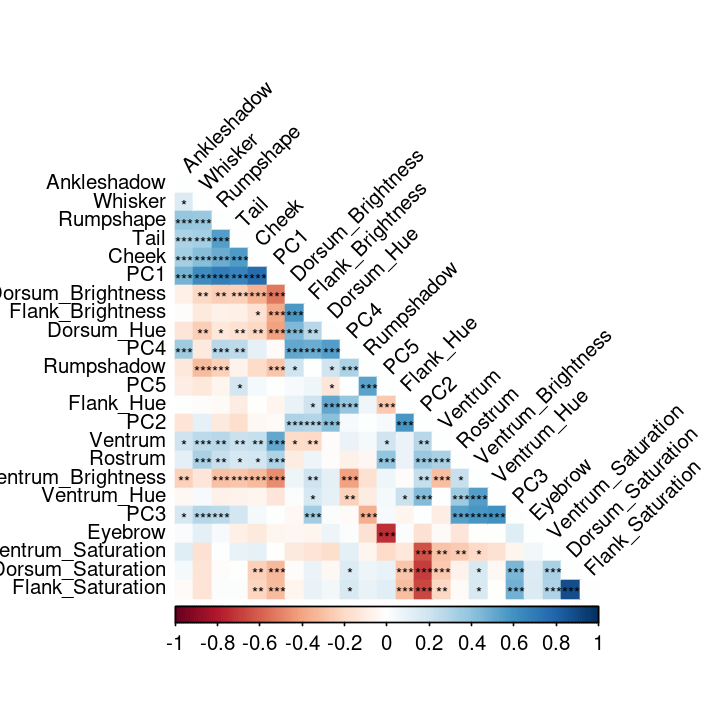

In [73]:
options(repr.plot.width = 6, repr.plot.height = 6)
corrplot(cor_mat, p.mat=cor_mat_sig$p, tl.col="black", hclust.method="ward.D2", order="hclust", cl.cex=1, 
        insig="label_sig", sig.level=c(.001, .01, .05), pch.cex=0.75, pch.col="black", type="lower", 
        method="color", tl.srt=45) #, tl.pos="rd", )


Version with ggplot, allowing for greater control (Fig. 2B)

Warning message:
“Outer names are only allowed for unnamed scalar atomic inputs”
Warning message:
“Outer names are only allowed for unnamed scalar atomic inputs”
Warning message:
“Outer names are only allowed for unnamed scalar atomic inputs”
Warning message:
“Outer names are only allowed for unnamed scalar atomic inputs”
Warning message:
“Removed 451 rows containing missing values (geom_text).”


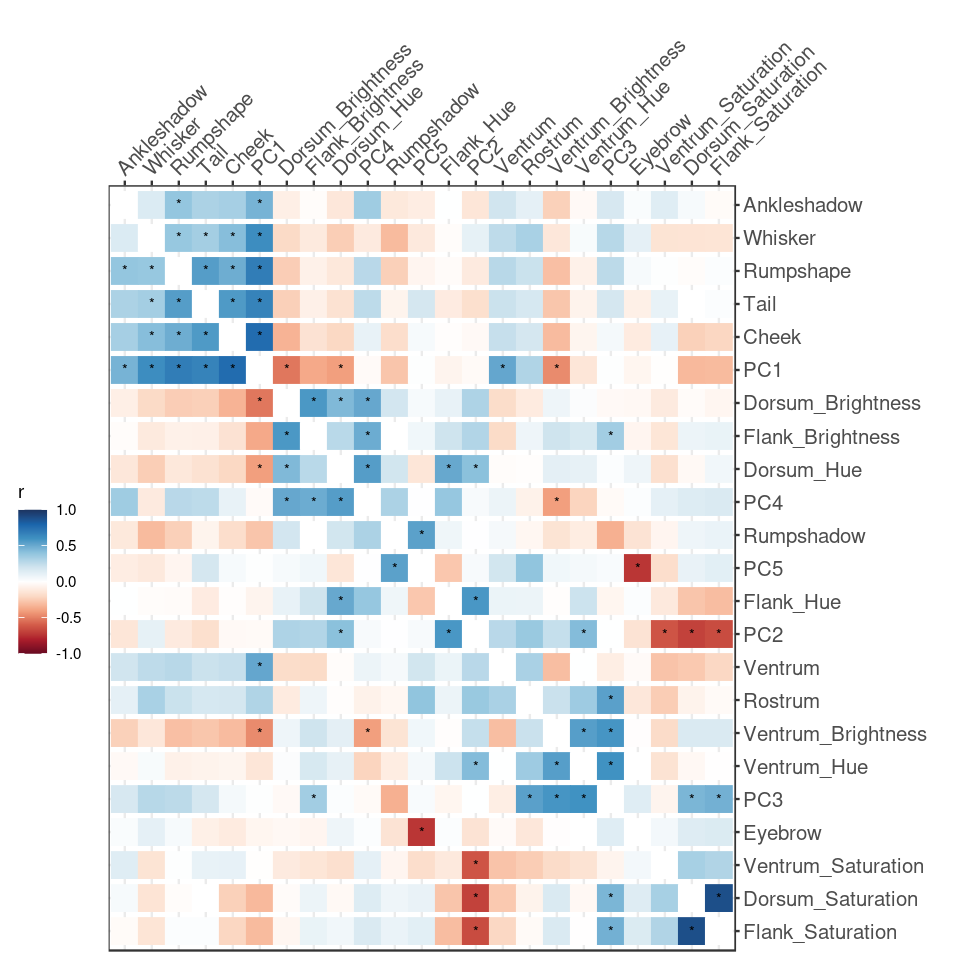

In [78]:
options(repr.plot.width = 8, repr.plot.height = 8)


##### DATA TRANSFORMATIONS #####
# cluster based on correlation <- transformed to distance
reorder_cormat <- function(cormat){
    dd <- as.dist((1-cormat)/2)
    hc <- hclust(dd, method="ward.D")
    cormat <- cormat[hc$order, hc$order]
}

# pull out order of traits based on clustering
trait_order <- rownames(reorder_cormat(cor_mat))

# tidy up cor. matrix
cor_mat_plot <- reorder_cormat(cor_mat) %>% as.data.frame() %>% rownames_to_column(var="Trait1") %>% 
    gather(key="Trait2", value="r", -Trait1) %>%
    mutate(Trait1=fct_relevel(Trait1, levels=trait_order)) %>%
    mutate(Trait2=fct_relevel(Trait2, levels=trait_order))

# pull out number of pairwise comparisons to correct for with Bonferroni
no_tests = cor_mat_sig$p %>% as.data.frame() %>% gather(key="Trait2", value="p") %>% nrow()

# ...and significance matrix (order both according to clustering)
cor_mat_sig_plot <- cor_mat_sig$p %>% as.data.frame() %>% 
    setNames(colnames(cor_mat)) %>% mutate(Trait1=rownames(cor_mat)) %>% 
    gather(key="Trait2", value="p", -Trait1) %>%
    mutate(significance = case_when(p < 0.001/no_tests ~ "*")) %>%
#    mutate(significance = case_when(p < 0.001/no_tests ~ "***",
#                                   p < 0.01/no_tests ~ "**",
#                                   p < 0.05/no_tests ~ "*")) %>%
    mutate(Trait1=fct_relevel(Trait1, levels=trait_order)) %>%
    mutate(Trait2=fct_relevel(Trait2, levels=trait_order))


##### PLOTTING #####
ggplot(cor_mat_plot) +
    geom_point(aes(x=Trait1, y=fct_relevel(Trait2,rev(trait_order)), color=r), size=7.5, shape=15) + #, size=r)) +
    #scale_color_gradient2(name="Correlation", limits=c(-1,1), midpoint=0, mid="white", 
    #                     low="#690A21",high="#1C3461") +
    scale_colour_gradientn(colours=
        c("#690A21","#AE1F2C","#D45D4A","#F3A280","#FBDBC7","white","#D1E5EF","#8FC4DE","#4092C2","#1A65AB","#1C3461"),
        values=c(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0), limits=c(-1,1)) +
    scale_size(guide="none") +
    theme_bw() + ylab("") + xlab("") +
    theme(axis.text.x = element_text(angle=45,hjust=0,size=12), legend.position="left") +
    theme(axis.text.y = element_text(size=12)) +
    scale_y_discrete(position="right") +
    scale_x_discrete(position="top") +
    geom_text(data=cor_mat_sig_plot, aes(x=Trait1,y=Trait2,label=significance),size=3, vjust=0.5)



#out_file = paste0(assoc_dir,"/traits.corrplot.p0.001.pdf")
#if (!exists(out_file)) {ggsave(out_file)}